### TODO:

- Gradient checks (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html)
- Hyper-parameter tuning (https://scikit-learn.org/stable/modules/grid_search.html)
- L2 Regularization on Weights (2 hidden, 128 units, ReLu)
- Make a PyTorch ConvNet (2 conv, 2 fully connected)
- Try to come up with an architecture that works best, compare with PyTorch ConvNet
- You can report your findings either in the form of a table or a plot in the write-up. 
   Include in your colab notebook plots of the testing and training accuracy of the MLPs/ConvNet as a function of training epochs. 
   This will allow you to see how much the network should be trained before it starts to overfit to the training data.
- Creativity:
    - Effect of width (number of hidden units)
    - Effect of batch-size
    - Effects of convolution hyper-parameter tuning on PyTorch ConvNet (number of filters, filter size, stride, padding)
    - Train with 10^k , k ∈ {0, 1, 2, 3, 4} images
    - Implement ConvNet (HARD)
- Note 2: We expect you to provide plots/tables in your report that justifies your choice of hyperparameters (the learning rates of the MLPs/ConvNets in parts 1-6, the architectural parameters of the MLPs/ConvNets in parts 5 & 6). You are not required to perform cross- validation in this assignment.

# Image Classification Using ConvNets

We will implement a Convolutional Neural Net from scratch to perform image classification. Many proven implementations of this ML model already exist and are available through free libraries such as tensorflow, pytorch etc. However we will not rely on these and instead build our own, to improve our understanding of what really is happening inside of the black box.

### Dataset

We will be working with [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist): a dataset containing 28x28 grayscale images of clothing articles. Although having the same type of input and range of labels, Fashion-MNIST is an alternative which is more challenging and better yet: more representative of modern image recognition problems; compared to the classic [MNIST](https://en.wikipedia.org/wiki/MNIST_database) we all know and love.

To download the dataset:

In [ ]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -P data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -P data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -P data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -P data

After doing this, make sure to unzip the tarballs in order

### Imports

In [1]:
import matplotlib.pyplot as plt
import mnist
import numpy as np
import time
import torch
from typing import List
from tqdm import tqdm

np.random.seed(42)

## Understanding the data

In [2]:
mndata = mnist.MNIST('data')

images_train, labels_train = mndata.load_training()
images_test, labels_test = mndata.load_testing()

In [3]:
X_train_raw = np.array(images_train, dtype=np.float64)
X_test_raw = np.array(images_test, dtype=np.float64)
Y_train_raw = np.array(labels_train, dtype=np.uint8)
Y_test_raw = np.array(labels_test, dtype=np.uint8)

In [4]:
print(X_train_raw.shape, X_train_raw.dtype)
print(Y_train_raw.shape, Y_train_raw.dtype)
print(X_test_raw.shape)
print(Y_test_raw.shape)

(60000, 784) float64
(60000,) uint8
(10000, 784)
(10000,)


We have 60000 training examples and 10000 testing examples. Each of these is a list of 784 numbers which represent each of the 28x28 pixels in the image. The value of the number represents how black the pixel is.

In [5]:
label_to_article_map= {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

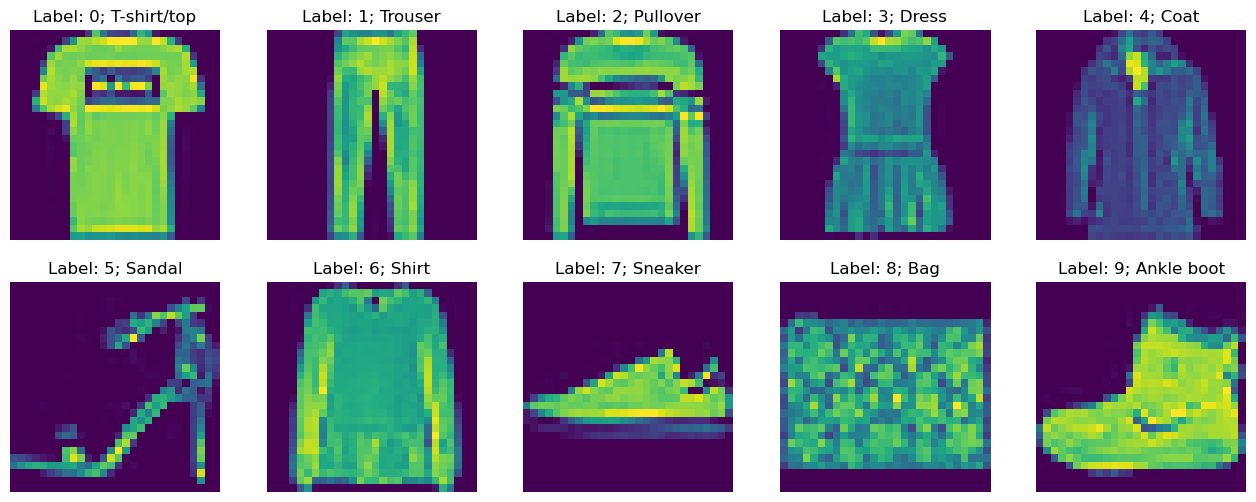

In [6]:
def display_image(index, fig, train=True):
    plt.show()
    

fig = plt.figure(figsize=(16,6))
rows = 2
columns = 5


for label in range(10):
    for n in range(len(X_train_raw)):
        if Y_train_raw[n] == label:
            fig.add_subplot(rows, columns, Y_train_raw[n] + 1)
            
            image = X_train_raw[n]
            label = Y_train_raw[n]

            image = np.array(image, dtype='float')
            pixels = image.reshape((28, 28))
            plt.imshow(pixels)
            plt.axis('off')
            plt.title(f"Label: {Y_train_raw[n]}; {label_to_article_map[Y_train_raw[n]]}")
            break

### Standardization

We will now standardize the data by pulling the mean to the center and adjusting the scale.

In [7]:
print(np.mean(X_test_raw))
print(np.mean(X_train_raw))

73.14656658163265
72.94035223214286


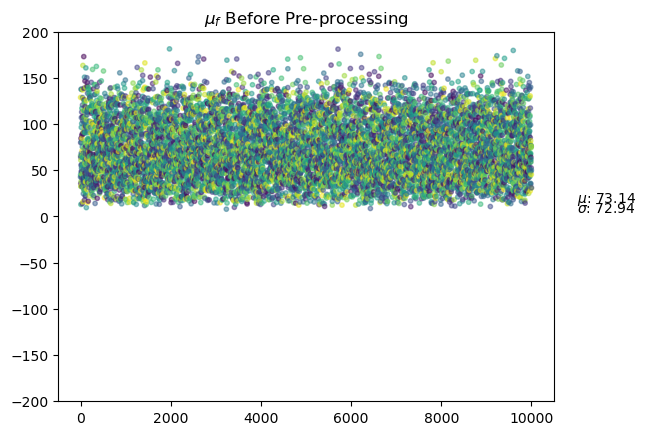

In [8]:
plt.scatter(np.arange(0, len(X_test_raw)), list(map(np.mean, X_test_raw)),  s=10,  alpha=.5, c = np.random.rand(X_test_raw.shape[0]))
plt.title(r"$\mu_f$ Before Pre-processing")
plt.text(11000, 15, r"$\mu$: 73.14")
plt.text(11000, 4, r"$\sigma$: 72.94")
plt.ylim(-200, 200)
plt.show()

In [9]:
# Centering
X_train = X_train_raw - np.mean(X_train_raw, axis=0)
X_test = X_test_raw - np.mean(X_test_raw, axis=0)

# Normalization
X_train = X_train / np.std(X_train_raw, axis = 0)
X_test = X_test / np.std(X_test_raw, axis = 0)

Y_train = Y_train_raw
Y_test = Y_test_raw

In [10]:
print(f"Mean X_train: {np.mean(X_train)}")
print(f"Mean X_test: {np.mean(X_test)}")
print()
print(f"Std X_train: {np.std(X_train)}")
print(f"Std X_test: {np.std(X_test)}")


Mean X_train: -1.8899470046408106e-18
Mean X_test: -1.522591576628786e-18

Std X_train: 1.000000000000002
Std X_test: 0.9999999999999976


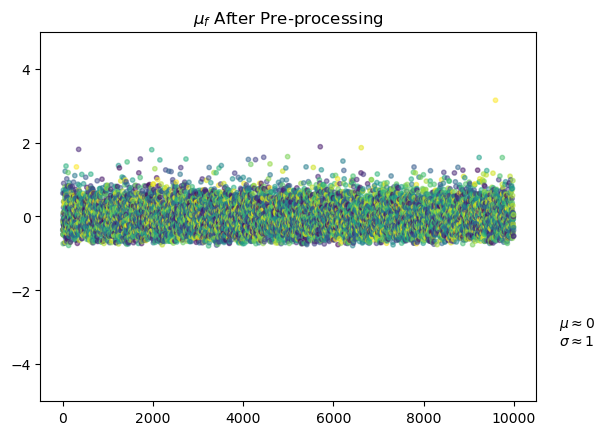

In [11]:
plt.scatter(np.arange(0, len(X_test)), list(map(np.mean, X_test)),  s=10,  alpha=.5, c = np.random.rand(X_test.shape[0]))
plt.title(r"$\mu_f$ After Pre-processing")
plt.text(11000, -3, r"$\mu \approx 0$")
plt.text(11000, -3.5, r"$\sigma \approx 1$")
plt.ylim(-5, 5)
plt.show()

We've effectively reduced the mean to 0 and the standard deviation to 1, completing the pre-processing stage.

## Multi-Layer Perceptron Implementation

Here we define a base class for one layer of our multi-layered perceptron.

### Neural Net Layers

Each layer implements two types of methods:
<ol>
    <li>forward(x): Process x using the activation function and return the result.
    </li>
    <li>backward(gradient): Take gradient calculated at the next layers, compute and return gradient at this layer.
    </li>
</ol>

And has two attributes:
<ol>
    <li>parameters: List of parameters (weight and bias).
    </li>
    <li>gradient: The gradient of the current layer.
    </li>
</ol>

In [12]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError
        
    def backward(self, gradient):
        raise NotImplementedError

We define the layers that implement this class, which are Linear, ReLu and Softmax. Note that although they all inherit from the same base class, they're vastly different.

- Linear layer simply applies the weight and bias to pass the input forwards.
- ReLu is our activation function.
- Softmax is our output function.

## TODO: Gradient Checks

In [13]:
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size, weights_varaince, bias_variance):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        np.random.seed(42)
        self.weights = np.random.randn(output_size, input_size) * weights_varaince
        # randn samples from N(0,1), we want a lower variance to avoid underflow in softmax
        
        np.random.seed(42) # the seed is consumed each time
        self.bias = np.random.randn(output_size) * bias_variance
        
        self.parameters = [self.weights, self.bias]
        self.cur_input = None
        
    def forward(self, x):
        self.cur_input = x
        return (self.weights[None, :, :] @ x[:, :, None]).squeeze() + self.bias
    
    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before calling backward!"
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.weights)


In [14]:
class ReLuLayer(NeuralNetLayer):
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before calling backward!"
        return gradient * self.gradient

In [15]:
class SoftMaxLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None
        
    def forward(self, x):
        copy = np.array(x, copy = True, dtype = np.float64)
        maximum = np.max(copy, axis=-1)[:, None]
        copy = copy - maximum # avoid overflow, result will be the same as -max()'s cancel out
        exps = np.exp(copy)

        exps[exps < 10**(-100)] = 10**(-100)
        exps[exps > 10**(100)] = 10**(100)
        
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs
    
    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before calling backward!"
        return self.cur_probs - target

### MLP Class

In [16]:
class MLP:
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

### Stochastic Gradient Descent with Batching

<ol>
    <li> During training, we choose a random subset (batch) of our data to use in our gradient calculation.
    <li> When we update the weights, we subtract the <strong>mean of our gradient</strong> times the learning rate. 
        <ul>
            <li> In contrast to regular gradient descent where we subtract the gradient itself.</li>
        </ul>
    <li> Then we do this again. Note that we decay the change in weights as epochs increase.
</ol>

In [17]:
class SGDOptimizer:
    def __init__(self, net: MLP, lr: float):
        self.net = net
        self.lr = lr

    def step(self, epoch):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient, epoch)

    def update(self, params, gradient, epoch):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g.mean(axis=0) / (epoch+1)

Note: mini-batching is used in fit.

In [18]:
def mini_batch(N,k):
    random_index_list = np.random.choice(N,N, replace= False)
    result = [list(random_index_list[x:x+k]) for x in range(0,N,k)]

    if len(result[-1]) != k:
        result.pop()

    return np.array(result)

### Fit & Predict

In [19]:
def fit(self, data_x, data_y, steps, batch_size, learning_rate):
    self.steps = steps
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.losses = []
    self.accuracies = []
    self.prediction_loss = 0
    self.prediction_acc = 0
    
    N = len(X_train)
    self.batches = mini_batch(N, self.batch_size)
    self.optimizer = SGDOptimizer(net = self, lr = self.learning_rate)
    
    labels = np.eye(np.max(data_y)+1)[np.array(data_y)]
    for epoch in tqdm(range(steps)):
        X = data_x[self.batches[epoch % len(self.batches)]]
        Y = labels[self.batches[epoch % len(self.batches)]]
        
        predictions = self.forward(X)
        
        if epoch % 10 == 0:
            self.losses.append(self.evaluate_loss(Y, predictions))
            self.accuracies.append(self.evaluate_acc(Y, predictions))
        
        self.backward(Y)
        self.optimizer.step(epoch)
        
MLP.fit = fit

In [20]:
def predict(self, data_x, data_y):
    C = np.max(data_y) + 1
    labels = np.eye(C)[np.array(data_y)]
    predictions = self.forward(data_x)
    
    self.prediction_loss = self.evaluate_loss(labels, predictions)
    self.prediction_acc = self.evaluate_acc(labels, predictions)
    
MLP.predict = predict

### Evaluation

We use accuracy and Cross-Entropy Loss to evaluate the performance of our model.

In [21]:
def evaluate_acc(self, y, y_hat):
    count = 0
    for i in range(len(y)):
        if np.argmax(y[i]) == np.argmax(y_hat[i]):
            count += 1
            
    return (count / len(y)) * 100

MLP.evaluate_acc = evaluate_acc

def evaluate_loss(self, y, y_hat):
    return -(y * np.log(y_hat)).sum(axis=-1).mean()

MLP.evaluate_loss = evaluate_loss

### Plot Helper

In [22]:
def plot(self):
    fig = plt.figure(figsize=(16,6))
    rows = 1
    columns = 2

    fig.add_subplot(rows, columns, 1)
    fig.suptitle("Training loss and accuracy", fontsize=20)
    if self.prediction_loss:
        plt.plot(len(self.losses), self.prediction_loss, color='red', marker='*', label=f"Test Loss: {self.prediction_loss:.3f}")
    plt.plot(self.losses, linewidth = .5, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.add_subplot(rows, columns, 2)
    plt.plot(self.accuracies, linewidth = .5, label="Training Accuracy")
    if self.prediction_acc:
        plt.plot(len(self.accuracies), self.prediction_acc, color='red', marker='*', label=f"Test Accuracy: {self.prediction_acc:.3f}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.show()
    
MLP.plot = plot

## Effect of Network Depth on Accuracy

We fix the following things as default: the input/output dimensions, the maximum number of iterations, the number of hidden units whenever there is a hidden layer, and the learning rate.

Different batch sizes and initial weight/bias for linear layers will be studied.

### Default Configurations:

In [23]:
hidden_units = 128
gradient_steps = 1500
learning_rate = 5e-2

D = X_train.shape[1]
C = np.max(Y_train) + 1

### 0 Hidden Layers (Linear + Softmax)

100%|██████████| 1500/1500 [00:00<00:00, 2889.83it/s]


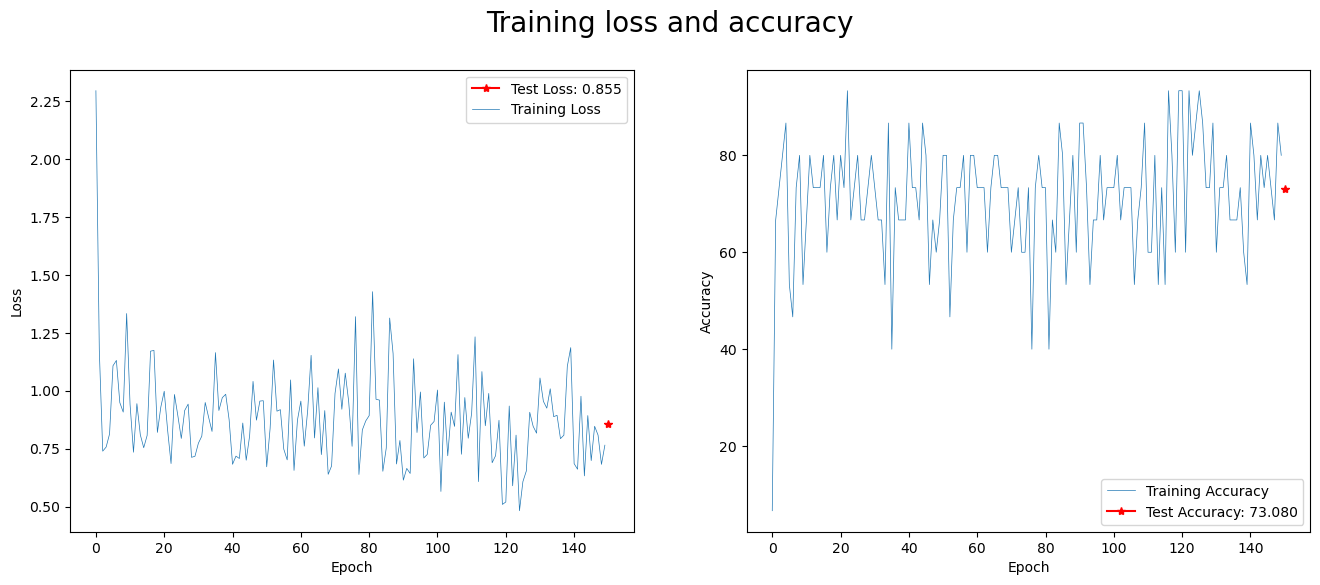

In [24]:
batch_size = 15
weights_varaince, bias_variance = 0.01,0.01
#np.random.seed(42)

no_hidden = MLP(
    LinearLayer(D, C, weights_varaince, bias_variance),
    SoftMaxLayer(),
)

no_hidden.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

no_hidden.predict(data_x = X_test, data_y = Y_test)
no_hidden.plot()

### 1 Hidden Layer, 128 Units, ReLu

100%|██████████| 1500/1500 [00:08<00:00, 176.76it/s]


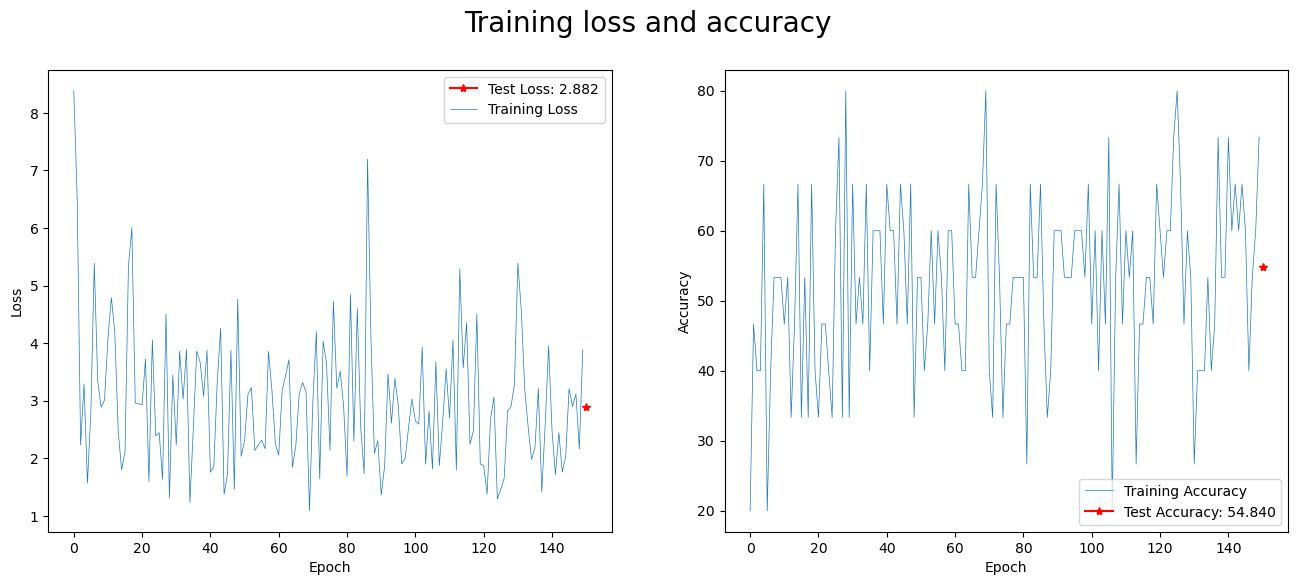

In [25]:
batch_size = 15
weights_varaince, bias_variance = 0.2,0.2
#np.random.seed(42)

one_hidden = MLP(
    LinearLayer(D, hidden_units, weights_varaince, bias_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, C, weights_varaince, bias_variance),
    SoftMaxLayer(),

)
one_hidden.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

one_hidden.predict(data_x = X_test, data_y = Y_test)
one_hidden.plot()

### 2 Hidden 128 Units (Normalized)

100%|██████████| 1500/1500 [00:10<00:00, 148.28it/s]


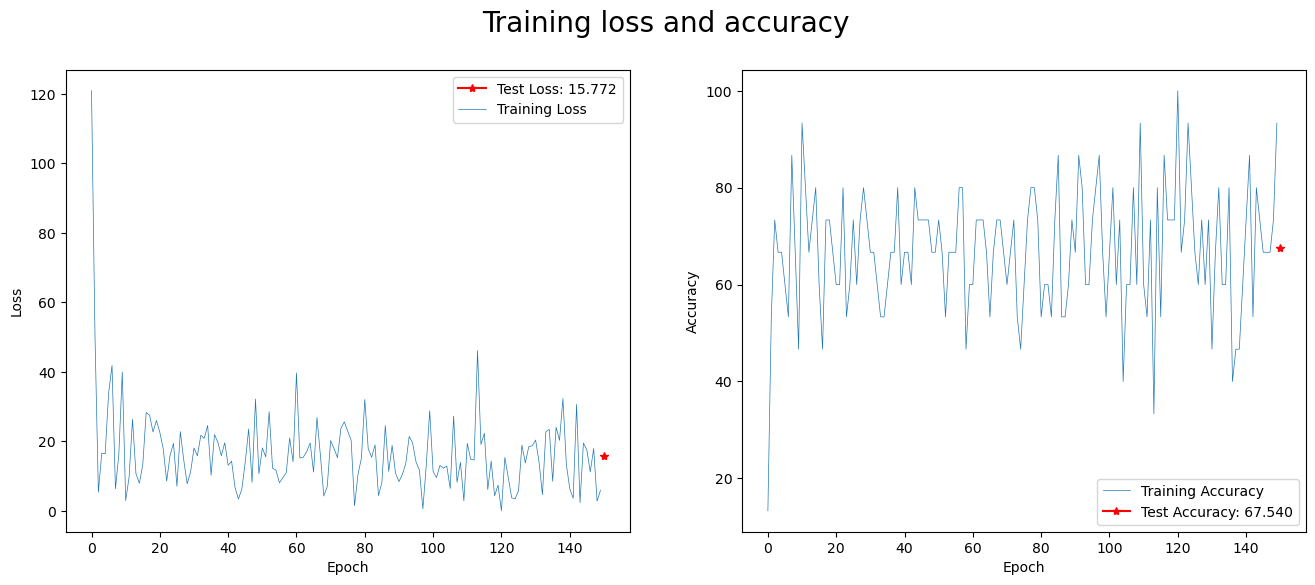

In [26]:
batch_size = 15
weights_varaince, bias_variance = 0.4,0.4
#np.random.seed(42)

two_hidden = MLP(
    LinearLayer(D, hidden_units, weights_varaince, bias_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, hidden_units, weights_varaince, bias_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, C, weights_varaince, bias_variance),
    SoftMaxLayer(),

)
two_hidden.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

two_hidden.predict(data_x = X_test, data_y = Y_test)
two_hidden.plot()

### 2 Hidden 128 Units (Unnormalized)

100%|██████████| 1500/1500 [00:10<00:00, 139.63it/s]


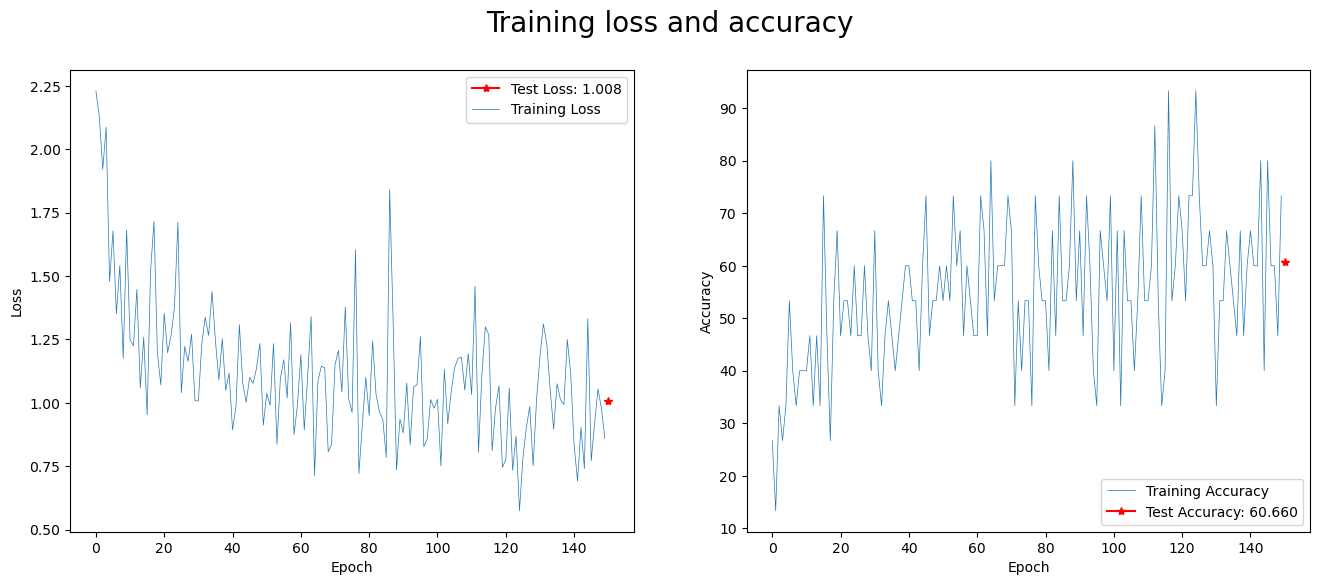

In [27]:
batch_size = 15
weights_varaince, bias_variance = 0.01,0.01
#np.random.seed(42)

two_hidden_unnormalized = MLP(
    LinearLayer(D, hidden_units, weights_varaince, bias_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, hidden_units, weights_varaince, bias_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, C, weights_varaince, bias_variance),
    SoftMaxLayer(),

)
two_hidden_unnormalized.fit(data_x = X_train_raw, data_y = Y_train_raw, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

#Remark: since we train on unnormalized images, we test on unnormalized images.
two_hidden_unnormalized.predict(data_x = X_test_raw, data_y = Y_test_raw)
two_hidden_unnormalized.plot()

As expected, we see a decrease in loss and an increase in accuracy as we increase the network depth. What's perhaps unexpected is that the change is quite minimal (between 1-3 with each added layer).

## Effect of Activation Function on Accuracy

Here we will compare the performance of different activation functions on the performance of our model

<h3 style="color: red;">IDEA</h3>
<p> We can implement sigmoid or other activations for creativity points!!</p>

### Leaky ReLu

Leaky ReLu is essentialy ReLu, which "leaks" a small portion of the negative values in its input. 

In [28]:
scalar = .02

<h3 style="color: red;">IDEA</h3>
<p> We can experiment with different scalars for creativity points!!</p>

In [29]:
class LeakyReLuLayer(NeuralNetLayer):
    def __init__(self, scalar):
        super().__init__()
        self.scalar = scalar
        
    def forward(self, x):
        self.gradient = np.where(x < 0, self.scalar, 1.0)
        return np.where(x < 0, x * self.scalar, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

100%|██████████| 1500/1500 [00:10<00:00, 139.11it/s]


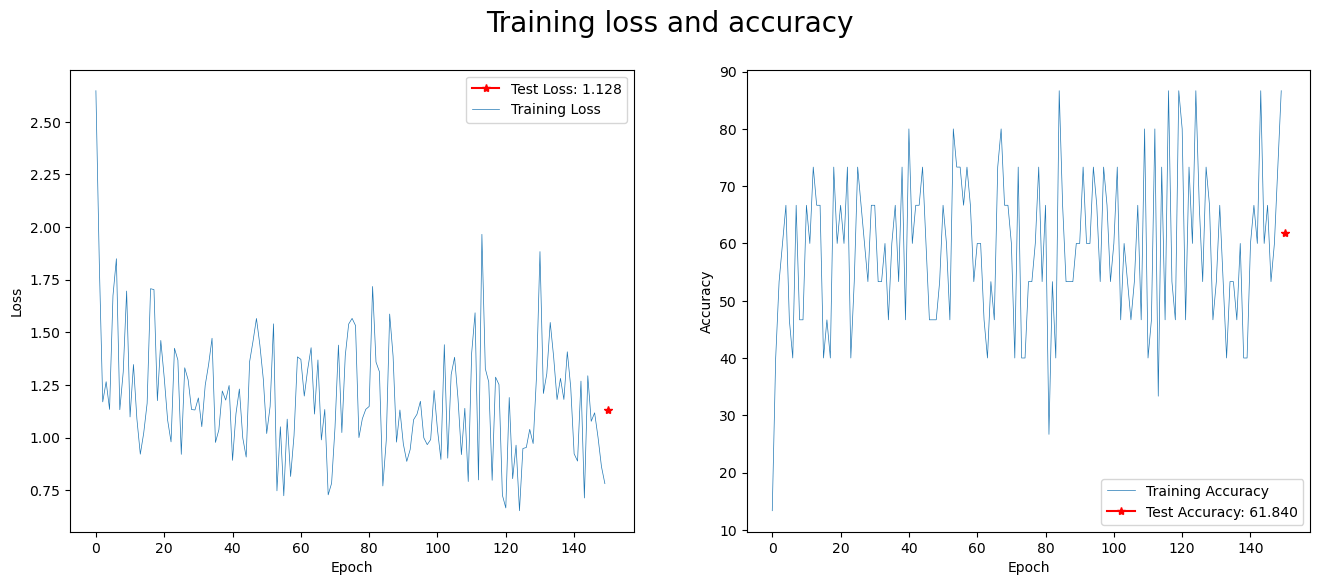

In [30]:
batch_size = 15
weights_varaince, bias_variance = 0.1,0.1
#np.random.seed(42)

leaky_two_hidden = MLP(
    LinearLayer(D, hidden_units, weights_varaince, bias_variance),
    LeakyReLuLayer(scalar),
    
    LinearLayer(hidden_units, hidden_units, weights_varaince, bias_variance),
    LeakyReLuLayer(scalar),
    
    LinearLayer(hidden_units, C, weights_varaince, bias_variance),
    SoftMaxLayer(),

)
leaky_two_hidden.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

leaky_two_hidden.predict(data_x = X_test, data_y = Y_test)
leaky_two_hidden.plot()

We see a slight accuracy increase of 0.4% by using Leaky ReLu here.

### Tanh

The hyperbolic tangent function is also a candidate for common activation functions. However, as it is a saturating activation function, we suspect it to perform worse than the other candidates.

In [31]:
class TanhLayer(NeuralNetLayer):

    def forward(self, x):
        self.gradient = 1 - np.tanh(x)**2
        return np.tanh(x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

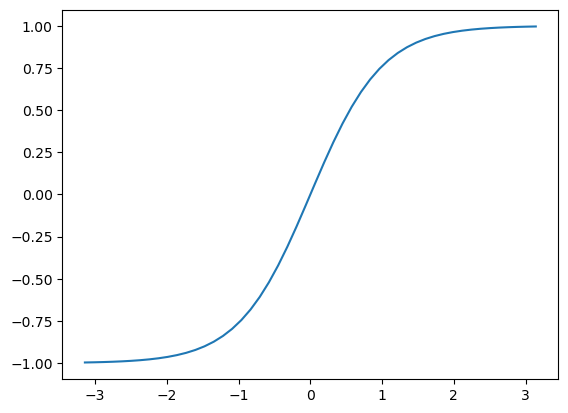

In [32]:
layer = TanhLayer()
x = np.linspace(-np.pi,np.pi)
y = layer.forward(x)
plt.plot(x, y)
plt.show()

100%|██████████| 1500/1500 [00:11<00:00, 130.24it/s]


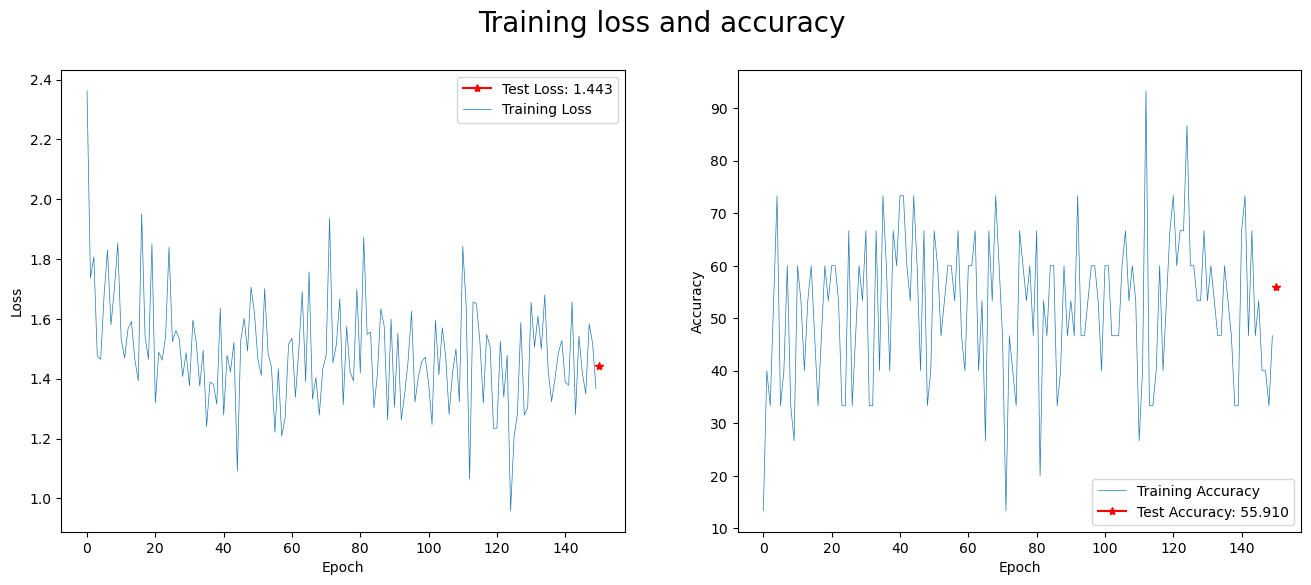

In [33]:
batch_size = 15
weights_varaince, bias_variance = 0.1,0.1
#np.random.seed(42)

tanh_two_hidden = MLP(
    LinearLayer(D, hidden_units, weights_varaince, bias_variance),
    TanhLayer(),
    
    LinearLayer(hidden_units, hidden_units, weights_varaince, bias_variance),
    TanhLayer(),
    
    LinearLayer(hidden_units, C, weights_varaince, bias_variance),
    SoftMaxLayer(),

)
tanh_two_hidden.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

tanh_two_hidden.predict(data_x = X_test, data_y = Y_test)
tanh_two_hidden.plot()

Our hypothesis turned out to be true: tanh performed considerably worse compared to LeakyReLu by 6% accuracy.

### Conclusion on Activation Functions

Since saturating activation functions may cause the gradient to vanish too quickly, we tend to prefer non-saturating ones. Although SGD is resilient to this, we still see a lower accuracy when using tanh.

Further, we see an increased accuracy using LeakyReLu. We suspect this might be because more information is used in calculating the activation: the negative part is still taken into consideration, whereas regular ReLu simply ignores the tail.

## TODO: L2 Regularization

## Training on Raw Data (BREAKS SOFTMAX)

During pre-processing, we have centered and normalized the data by subtracting the mean and dividing by the standard deviation. In this stage we will examine the performance of our model with un-processed data.

We will use the LeakyReLu two hidden model as it's the one that has achieved the highest accuracy so far.

  0%|          | 0/1500 [00:00<?, ?it/s]C:\Users\r2d2w\AppData\Local\Temp\ipykernel_31468\2924794964.py:19: RuntimeWarning: overflow encountered in matmul
  return (self.weights[None, :, :] @ x[:, :, None]).squeeze() + self.bias
C:\Users\r2d2w\AppData\Local\Temp\ipykernel_31468\2924794964.py:19: RuntimeWarning: invalid value encountered in matmul
  return (self.weights[None, :, :] @ x[:, :, None]).squeeze() + self.bias
C:\Users\r2d2w\AppData\Local\Temp\ipykernel_31468\3453468609.py:13: RuntimeWarning: invalid value encountered in greater
  exps[exps > 10**(100)] = 10**(100)
100%|██████████| 1500/1500 [00:12<00:00, 123.34it/s]


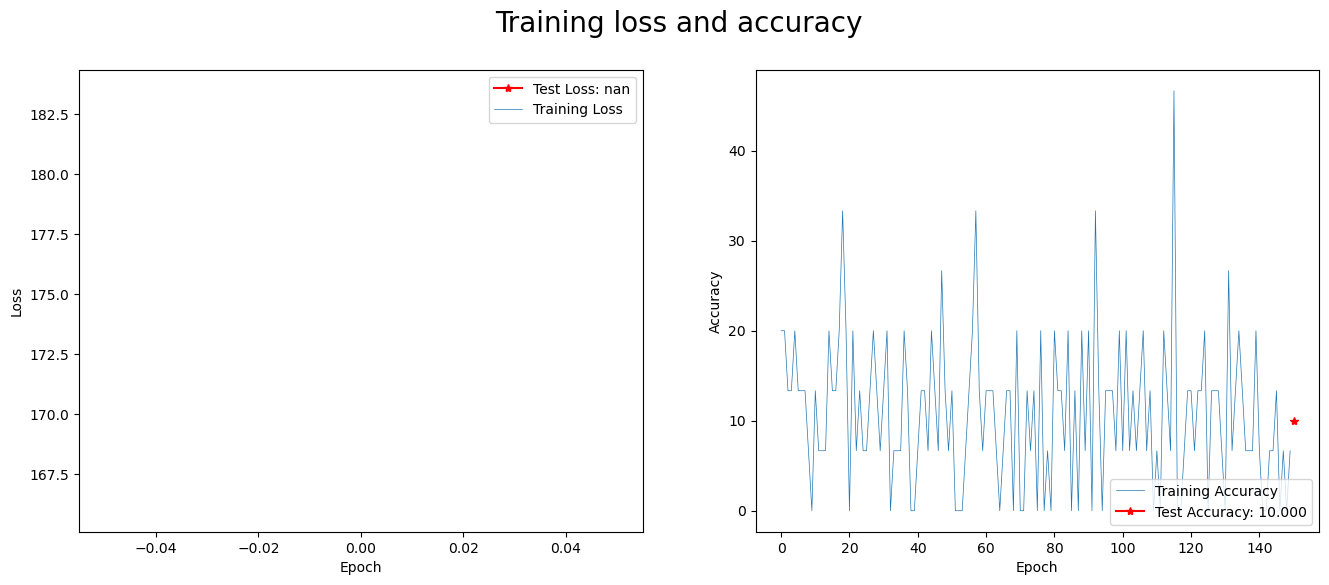

In [34]:
batch_size = 15
weights_varaince, bias_variance = 0.3,0.3
#np.random.seed(42)

leaky_two_hidden = MLP(
    LinearLayer(D, hidden_units, weights_varaince, bias_variance),
    LeakyReLuLayer(scalar),
    
    LinearLayer(hidden_units, hidden_units, weights_varaince, bias_variance),
    LeakyReLuLayer(scalar),
    
    LinearLayer(hidden_units, C, weights_varaince, bias_variance),
    SoftMaxLayer(),

)
leaky_two_hidden.fit(data_x = X_train_raw, data_y = Y_train_raw, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

leaky_two_hidden.predict(data_x = X_test_raw, data_y = Y_test_raw)
leaky_two_hidden.plot()

## TODO: PyTorch ConvNet

In [35]:
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [36]:
X_train_torch = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_train_torch  = torch.from_numpy(X_train_torch)

X_test_torch = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_test_torch  = torch.from_numpy(X_test_torch)

Y_train_torch = Y_train.astype(int);
Y_train_torch = torch.from_numpy(Y_train)

Y_test_torch = Y_test.astype(int);
Y_test_torch = torch.from_numpy(Y_test)

X_train_torch.shape, X_test_torch.shape, Y_train_torch.shape, Y_test_torch.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

In [37]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.cnn_layers = Sequential(
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),

            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 10)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        print("Testing")
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [38]:
model = SimpleCNN()
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
    
print(model)

SimpleCNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [39]:
def train(epoch):
    model.train()
    train_losses = []
    tr_loss = 0
    
    data_x, data_y = Variable(X_train_torch.float()), Variable(Y_train_torch)
        

    optimizer.zero_grad()
    output_train = model(data_x)
    loss_train = criterion(output_train, data_y)
    train_losses.append(loss_train)

    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch % 2 == 0:
        print(f'Epoch : {epoch+1}, loss: {loss_train}')
        
    return train_losses

In [40]:
n_epochs = 25

for epoch in range(n_epochs):
    train(epoch)

c:\Users\r2d2w\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Testing


RuntimeError: expected scalar type Long but found Byte

## TODO: Find Best MLP Architecture

## TODO: Creativity: Effect of Width

## TODO: Creativity: Effect of batch-size

## TODO: Creativity: Effect of Convolution Hyper-Parameter Tuning (PyTorch)

## TODO: Creativity: Effect of sample size 10^k , k ∈ {0, 1, 2, 3, 4} images

## TODO: Creativity: Implement Convolution & Pooling Layers